# Оптимизация маркетинговых затрат в Яндекс.Афише

### Описание проекта
Цель проекта - помочь маркетологам оптимизировать маркетинговые затраты и изучить

- как люди пользуются продуктом;
- когда они начинают покупать;
- сколько денег приносит каждый клиент;
- когда клиент окупается.

### Оглавление:
- [Описание данных](#Описание-данных)
- [Открытие и подготовка данных](#Шаг-1.-Открытие-и-подготовка-данных)
- [Построение отчета и подсчет метрик](#Шаг-2.-Построение-отчета-и-подсчет-метрик)
    - [Продукт](#Продукт)
    - [Продажи](#Продажи)
    - [Маркетинг](#Маркетинг)
- [Вывод](#Шаг-3.-Вывод)

### Описание данных

Источники - данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта Яндекс.Афиши,
выгрузка всех заказов за этот период,
статистика рекламных расходов.

Таблица `visits` (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя;
- Device — категория устройства пользователя;
- Start Ts — дата и время начала сессии;
- End Ts — дата и время окончания сессии;
- Source Id — идентификатор рекламного источника, из которого пришел пользователь.

Таблица `orders` (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ;
- Buy Ts — дата и время заказа;
- Revenue — выручка Яндекс.Афиши с этого заказа.

Таблица `costs` (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника;
- dt — дата;
- costs — затраты на этот рекламный источник в этот день.

### Шаг 1. Открытие и подготовка данных

[Вернуться в начало](#Оптимизация-маркетинговых-затрат-в-Яндекс.Афише)

In [38]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt

In [39]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [40]:
display(visits.head())
display(visits.info())

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

Создадим функцию, которая приводит названия колонок в таблице к нижнему регистру и заменяет пробелы на нижнее подчеркивание:

In [41]:
def low_space(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_')

Применим ее для таблицы `visits`:

In [42]:
low_space(visits)

In [43]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [44]:
display(orders.head())
display(orders.info())

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

In [45]:
low_space(orders)

In [46]:
orders['revenue'].sum()

252057.19999999998

In [47]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [48]:
display(costs.head())
display(costs.info())

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

In [49]:
costs['dt'] = pd.to_datetime(costs['dt'])

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий ревьюера</h1>

Ты почти ничего не сказал, про данные, которыми мы располагаем. Все же делать предобработку без комментариев - это не верно.
    
Здесь стоило отдельно отметить, что данные достаточно чистые и нужно только преобразовать даты. Само отсутствие пропусков и аномалий в данных - это тоже важно для клиента. Значит, он все делает правильно в плане сбора и хранения данных.
</div>

### Шаг 2. Построение отчета и подсчет метрик

[Вернуться в начало](#Оптимизация-маркетинговых-затрат-в-Яндекс.Афише)

### Продукт

Посчитаем, **сколько людей пользуются сервисов в день, неделю, месяц**.

Добавим в таблицу год, месяц, номер недели и дату сессии:

In [50]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].astype('datetime64[M]') # visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

In [51]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'})
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})

print('Людей пользуется в день:', int(dau_total.mean()))
print('Людей пользуется в неделю:', int(wau_total.mean()))
print('Людей пользуется в месяц:', int(mau_total.mean()))

Людей пользуется в день: 907
Людей пользуется в неделю: 5716
Людей пользуется в месяц: 23228


Изучим динамику показателей:

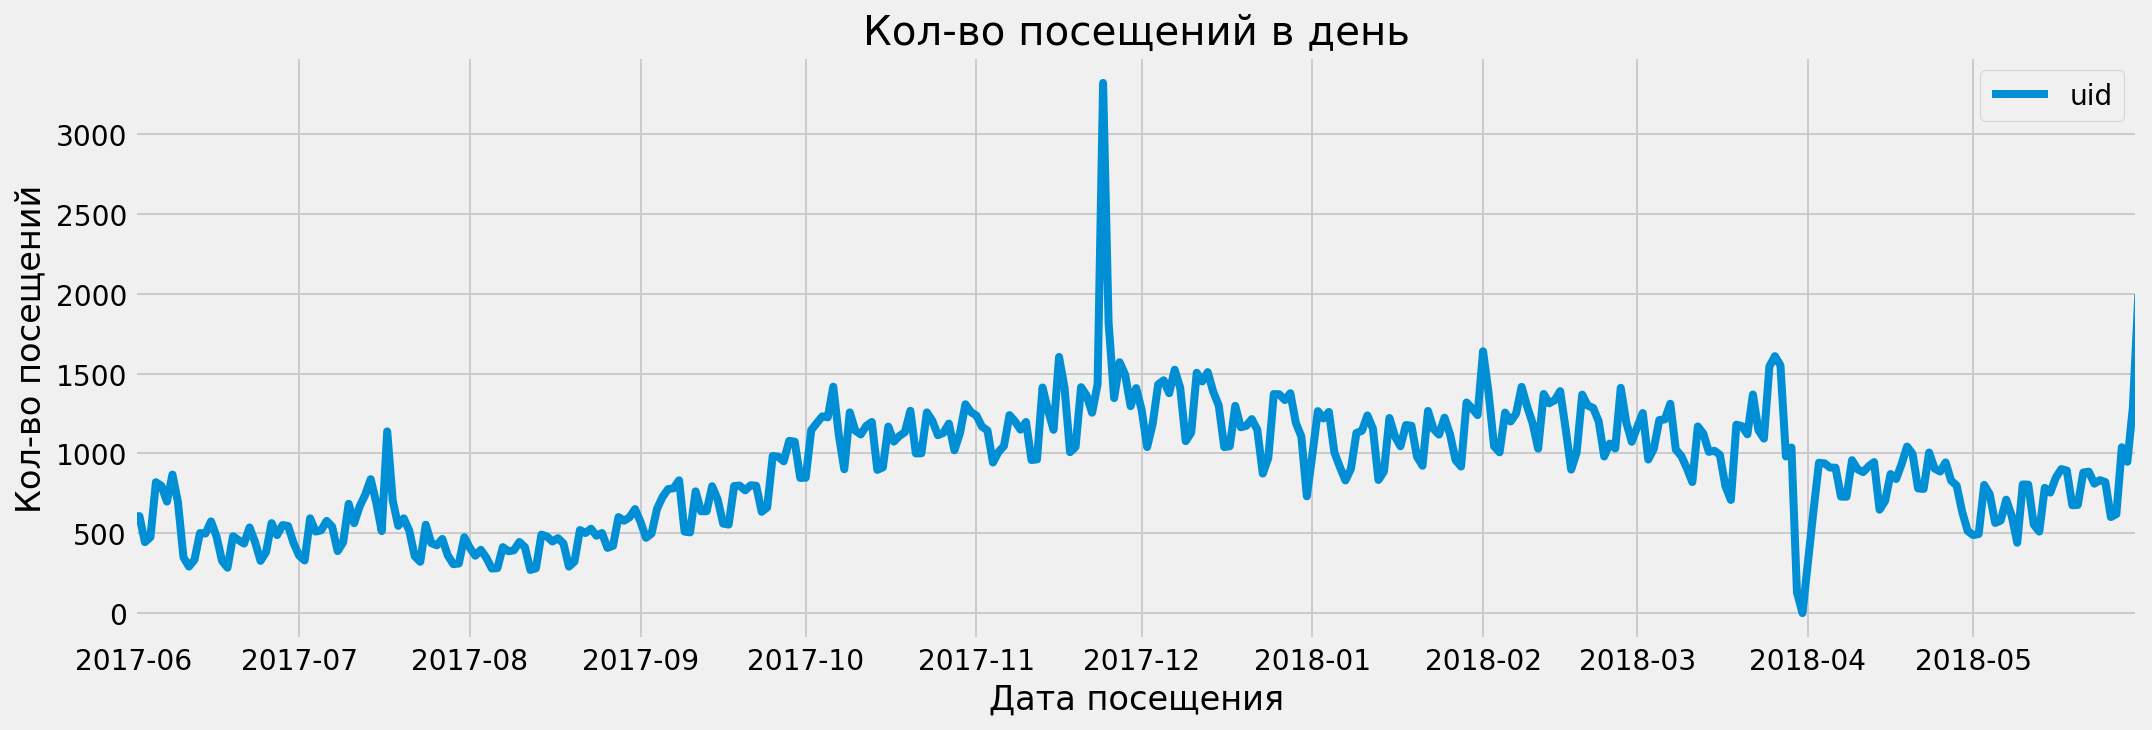

In [52]:
ax = dau_total.plot(figsize=((16, 5)));

ax.set_xlabel('Дата посещения');
ax.set_ylabel('Кол-во посещений');
ax.set_title('Кол-во посещений в день');

Видим выбивающееся значение, найдем его:

In [53]:
dau_total.sort_values('uid').tail()

,uid
session_date,
2018-03-26,1609
2018-02-01,1640
2017-11-25,1817
2018-05-31,1997
2017-11-24,3319


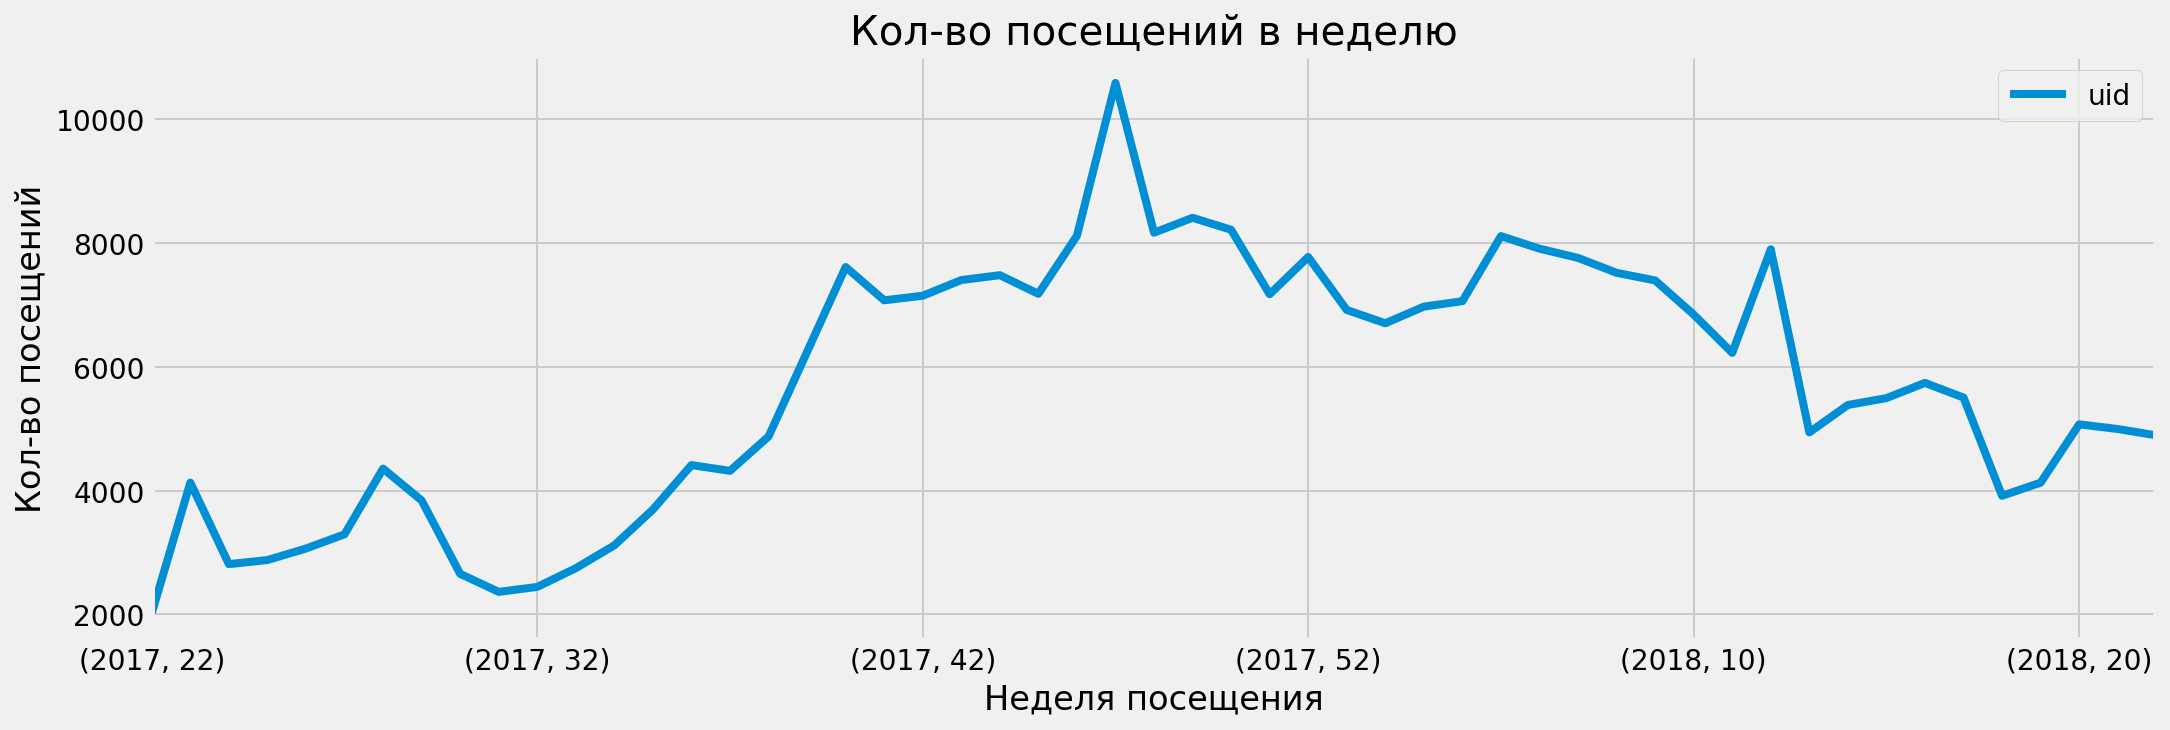

In [54]:
ax = wau_total.plot(figsize=(16, 5));

ax.set_xlabel('Неделя посещения');
ax.set_ylabel('Кол-во посещений');
ax.set_title('Кол-во посещений в неделю');

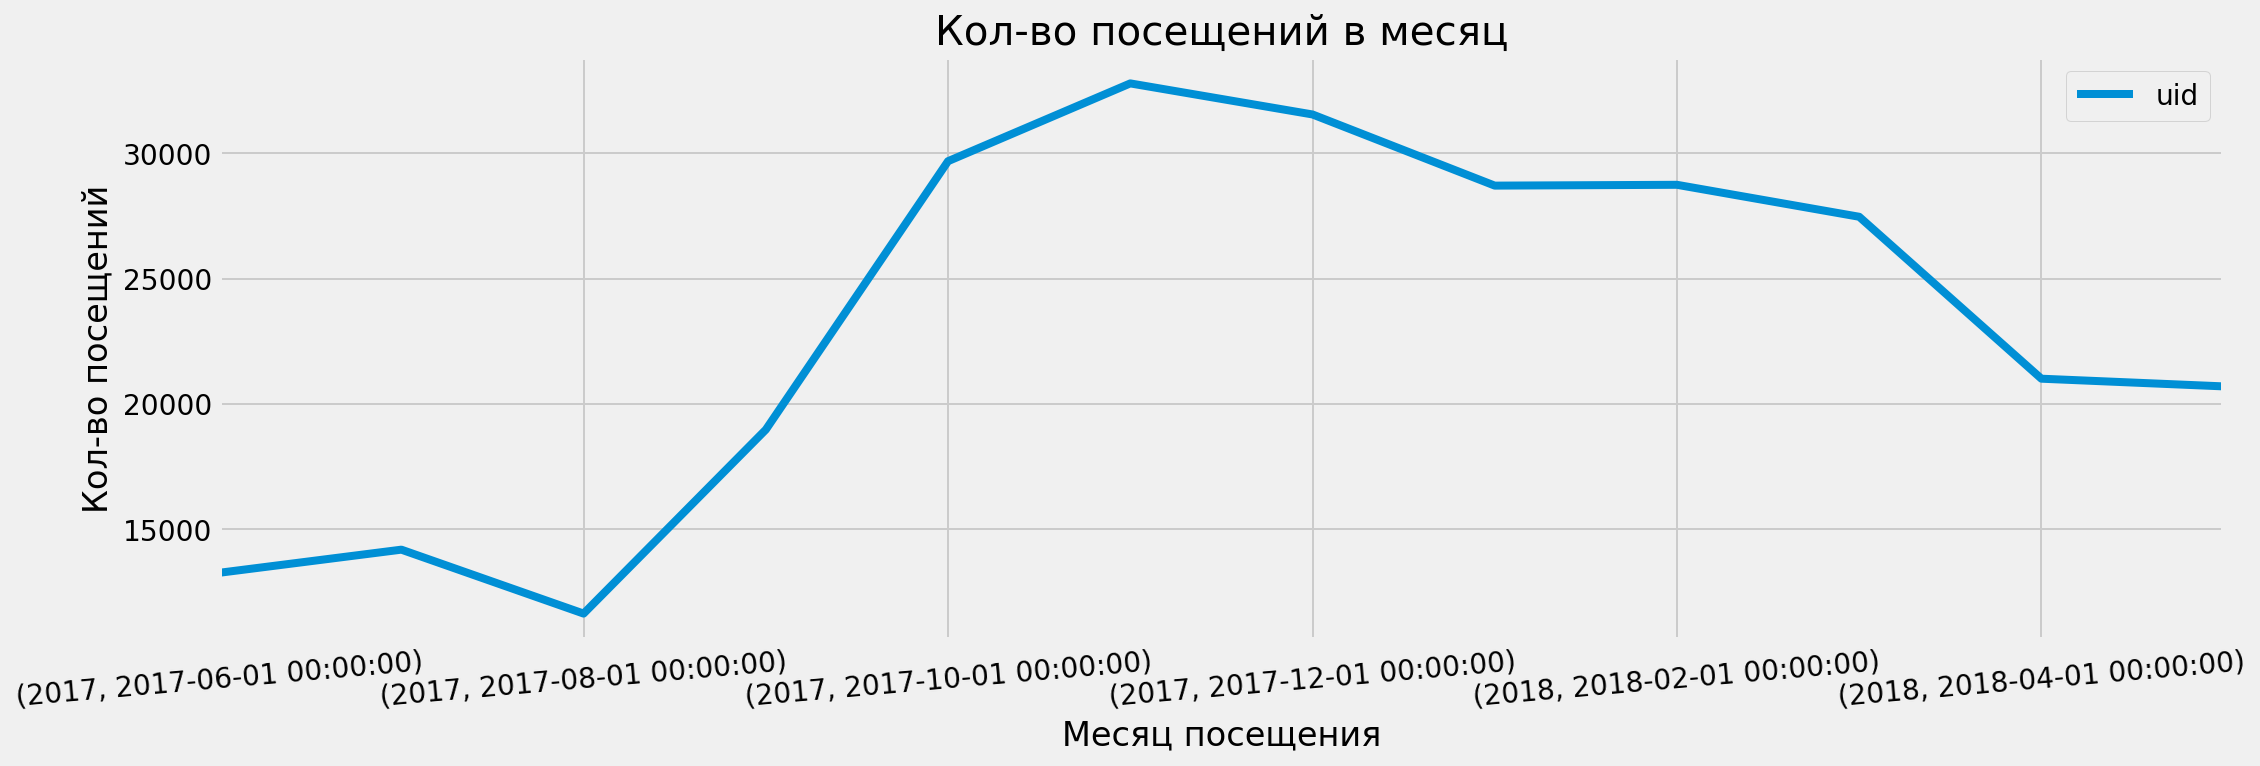

In [55]:
ax = mau_total.plot(figsize=(16, 5), rot=5);

ax.set_xlabel('Месяц посещения');
ax.set_ylabel('Кол-во посещений');
ax.set_title('Кол-во посещений в месяц');

После августа 2017 замечаем увеличение среднего числа посещений.

Посчитаем **количество сессий в день**:

In [56]:
session_cnt = visits.groupby('session_date').agg({'uid': 'count'}).mean()
print(session_cnt)

uid    987.362637
dtype: float64


Посчитаем **длительность одной сессии**:

In [57]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [58]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,52,2017-12-27,0


Видим сессии с нулевой продолжительностью. Посчитаем их долю:

In [59]:
len(visits.query('duration == 0')) / len(visits)

0.0995937673900946

Выведем гистограмму длительностей сессий:

In [60]:
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

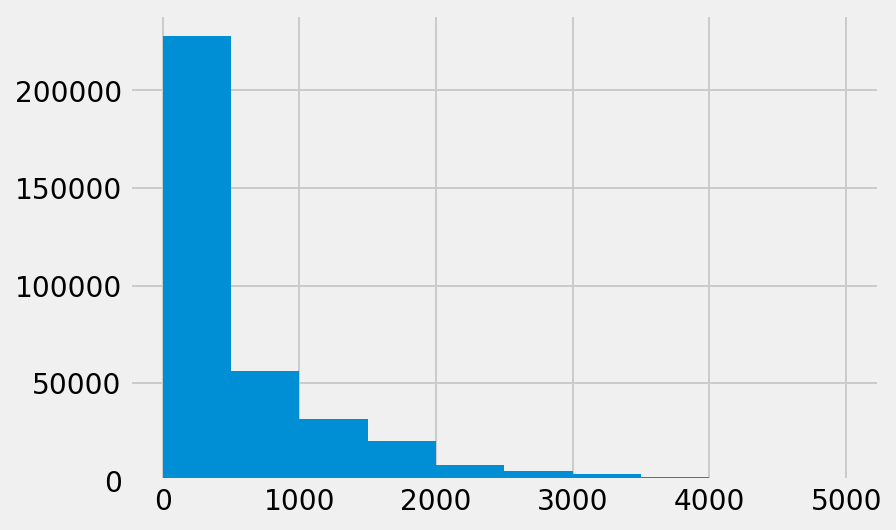

In [61]:
visits['duration'].hist(range=(0,5000));

Расчитаем среднюю длительность сессии:

In [62]:
asl = visits['duration'].mean()
print('ASL:', asl)

ASL: 643.506488592098


Видим, что длитльности имеют експоненциальное распределение.

Узнаем, **как часто люди возвращаются**:

Для каждой строки датафрейма рассчитаемдату и месяц первой сессии, а также lifetime пользователя в рамках когорты:

In [63]:
first_activity_ts = visits.groupby(['uid'])['start_ts'].min()
first_activity_ts.name = 'first_session_ts'

visits = visits.join(first_activity_ts,on='uid')

visits['first_session_month'] = visits['first_session_ts'].astype('datetime64[M]')
visits['first_session_date'] = visits['first_session_ts'].dt.date

visits['cohort_lifetime'] = ((visits['start_ts'] - visits['first_session_ts']) / np.timedelta64(1,'M')).round()#.astype('int')

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни». Найдем Retention Rate, разделив количество активных пользователей в каждый из месяцев на исходное число пользователей в когорте:

In [65]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,duration,first_session_ts,first_session_month,first_session_date,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,2017-12-20,0.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,2018-02-19,0.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2018-03-09,2.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,52,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,2017-12-27,0.0


In [66]:
cohorts = visits.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

cohorts = cohorts.merge(initial_users_count,on='first_session_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

cohorts.head()

,first_session_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0.0,13259,13259,1.000000
1,2017-06-01,1.0,986,13259,0.074365
2,2017-06-01,2.0,710,13259,0.053549
3,2017-06-01,3.0,813,13259,0.061317
4,2017-06-01,4.0,921,13259,0.069462


Построим сводную таблицу и создадим тепловую карту:

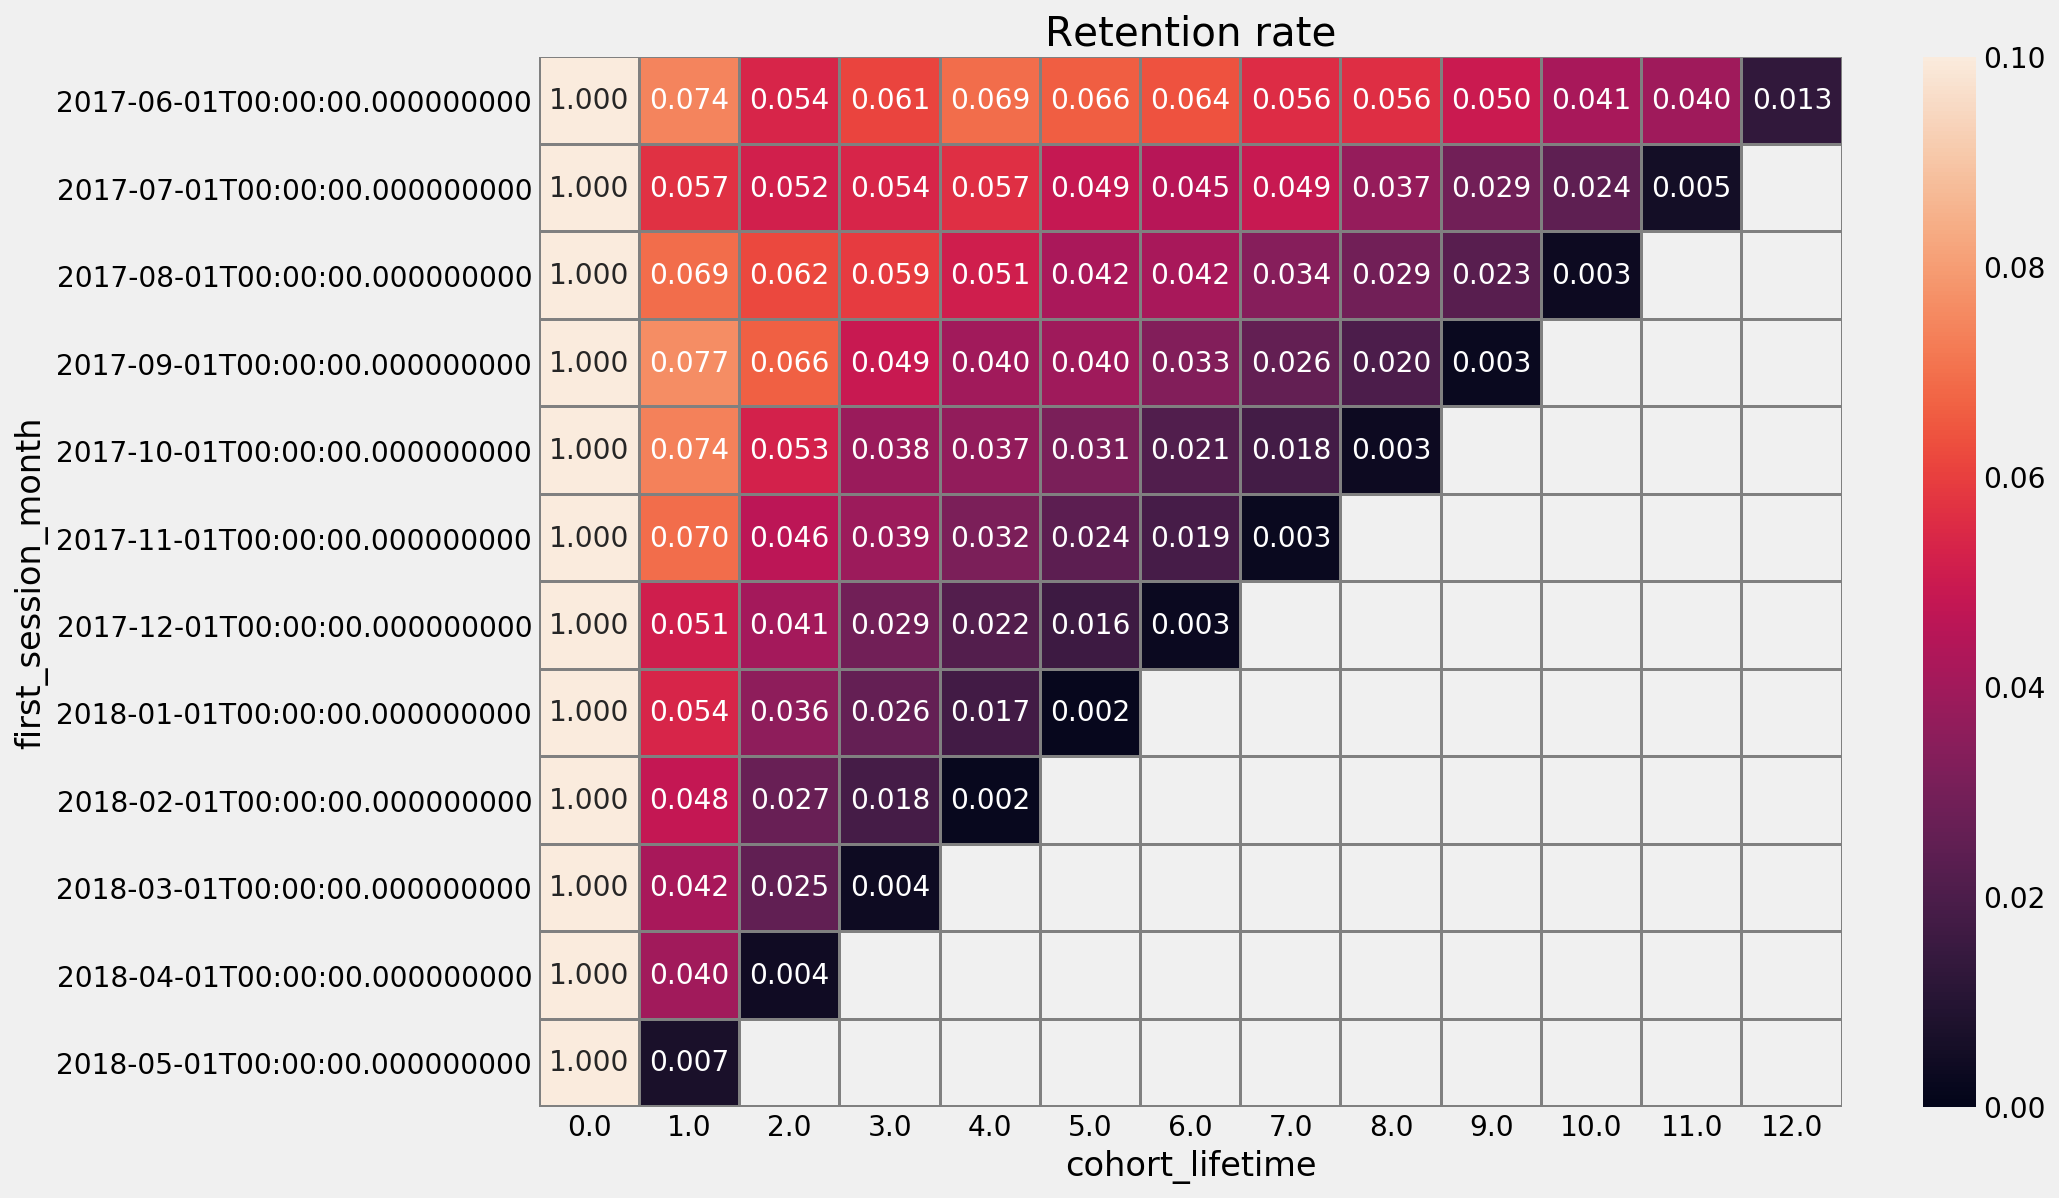

In [67]:
retention_pivot = cohorts.pivot_table(index='first_session_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
#display(retention_pivot)

plt.figure(figsize=(13, 9))
plt.title('Retention rate')
sns.heatmap(retention_pivot, annot=True, fmt='.3f', linewidths=1, linecolor='gray', vmin=0, vmax=0.1);

Retention rate резко падает уже в первом месяце, и остается почти неизменным в дальнейшем.

### Продажи

[Вернуться в начало](#Оптимизация-маркетинговых-затрат-в-Яндекс.Афише)

Узнаем, когда люди **начинают покупать**:

In [68]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [69]:
orders['purchase_year'] = orders['buy_ts'].dt.year
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['purchase_week']  = orders['buy_ts'].dt.week
orders['purchase_date'] = orders['buy_ts'].dt.date

In [70]:
orders['revenue'].sum()

252057.19999999998

In [71]:
first_purchase_date = orders.groupby(['uid'])['purchase_date'].min()
first_purchase_date.name = 'first_purchase_date'

orders = orders.join(first_purchase_date,on='uid')
display(orders.head())

,buy_ts,revenue,uid,purchase_year,purchase_month,purchase_week,purchase_date,first_purchase_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,2017-06-01,22,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,2017-06-01,22,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,2017-06-01,22,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,2017-06-01,22,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,2017-06-01,22,2017-06-01,2017-06-01


Найдем **разницу между покупкой и первой покупкой**:

In [72]:
print(orders['revenue'].sum(), len(orders))

252057.19999999998 50415


In [73]:
visits_first_session = visits[['uid', 'first_session_date']].drop_duplicates(subset=['uid'])

orders = orders.merge(visits_first_session,on='uid')
orders.head()

,buy_ts,revenue,uid,purchase_year,purchase_month,purchase_week,purchase_date,first_purchase_date,first_session_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01


In [74]:
print(orders['revenue'].sum(), len(orders))

252057.2 50415


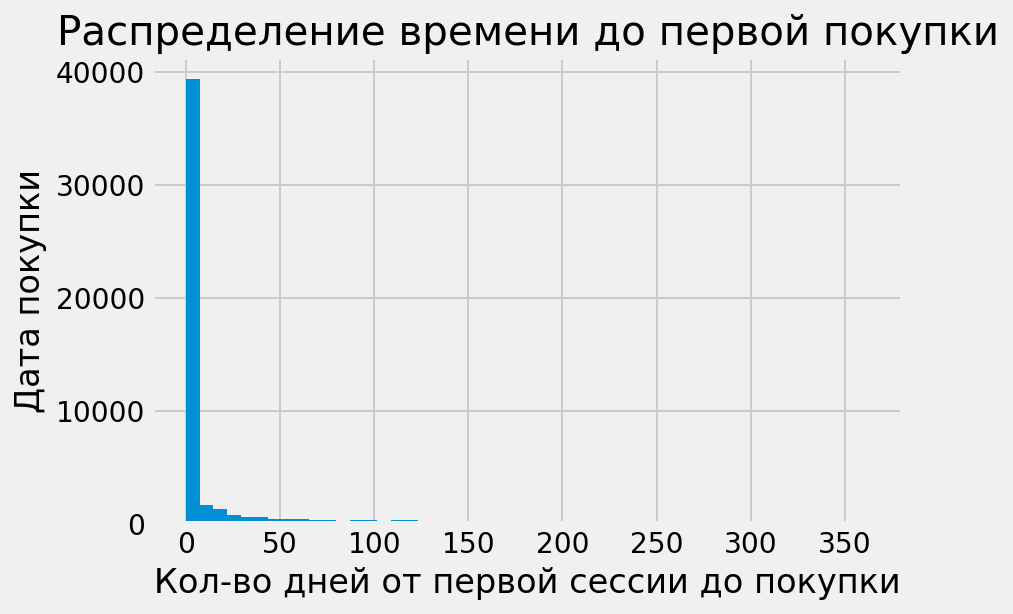

In [76]:
orders['first_purchase_days'] = orders['first_purchase_date'] - orders['first_session_date']
orders['first_purchase_days'] = orders['first_purchase_days'].dt.days

a1 = orders['first_purchase_days'].hist(bins=50);
a1.set_xlabel('Кол-во дней от первой сессии до покупки');
a1.set_ylabel('Дата покупки');
a1.set_title('Распределение времени до первой покупки');

Выведем параметры распределения:

In [77]:
orders['revenue'].sum()

252057.2

In [78]:
orders['first_purchase_days'].describe().to_frame()

,first_purchase_days
count,50415.000000
mean,17.611227
std,46.469172
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,363.000000


Видим, что *повторных покупок очень мало* и что в основном от первой сессии до покупки проходит *менее 30 дней*.

Посчитаем **количество покупок за период**:

In [79]:
orders_by_date = orders.groupby('purchase_date').agg({'uid': 'nunique'})
orders_by_week = orders.groupby(['purchase_year', 'purchase_week']).agg({'uid': 'nunique'})
orders_by_month = orders.groupby(['purchase_year', 'purchase_month']).agg({'uid': 'nunique'})

purchase_per_day = orders_by_date.mean()
purchase_per_week = orders_by_week.mean()
purchase_per_month = orders_by_month.mean()

print('Покупок за день:', int(purchase_per_day))
print('Покупок за неделю:', int(purchase_per_week))
print('Покупок за месяц:', int(purchase_per_month))

Покупок за день: 127
Покупок за неделю: 816
Покупок за месяц: 3155


Построим **графики количесвта покупок в день, неделю и месяц**:

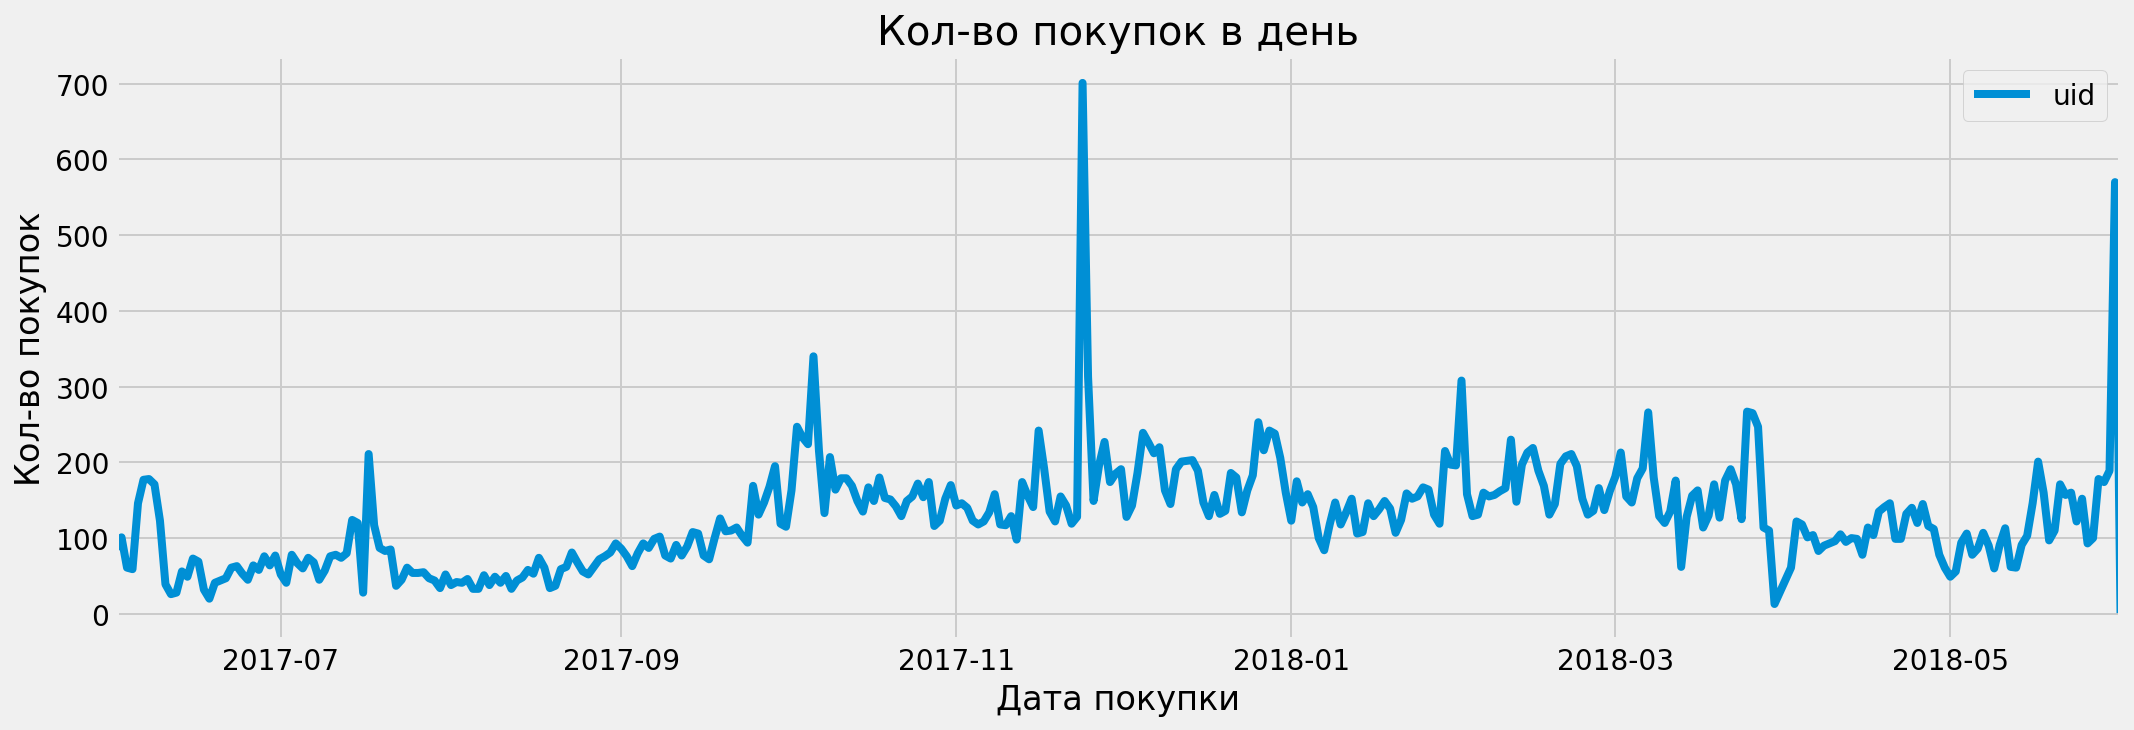

In [80]:
a1 = orders_by_date.plot(figsize=(16, 5));
a1.set_xlabel('Дата покупки');
a1.set_ylabel('Кол-во покупок');
a1.set_title('Кол-во покупок в день');

Замечаем *два сильно выделяющихся дня*. Выведем эти строки:

In [81]:
orders_by_date.sort_values('uid').tail(2)

,uid
purchase_date,
2018-05-31,570
2017-11-24,701


Всплески совпадают по датам со всплесками в графиках посещений.

Всплески на графике должны предшествовать каким-то событиям (фильмы/концерты/выставки), билеты на которые покупали пользователи Яндекс.Афиши. Эти два события явно вызвали особенный ажиотаж. Стоило бы по ним провести дополнительное исследование.

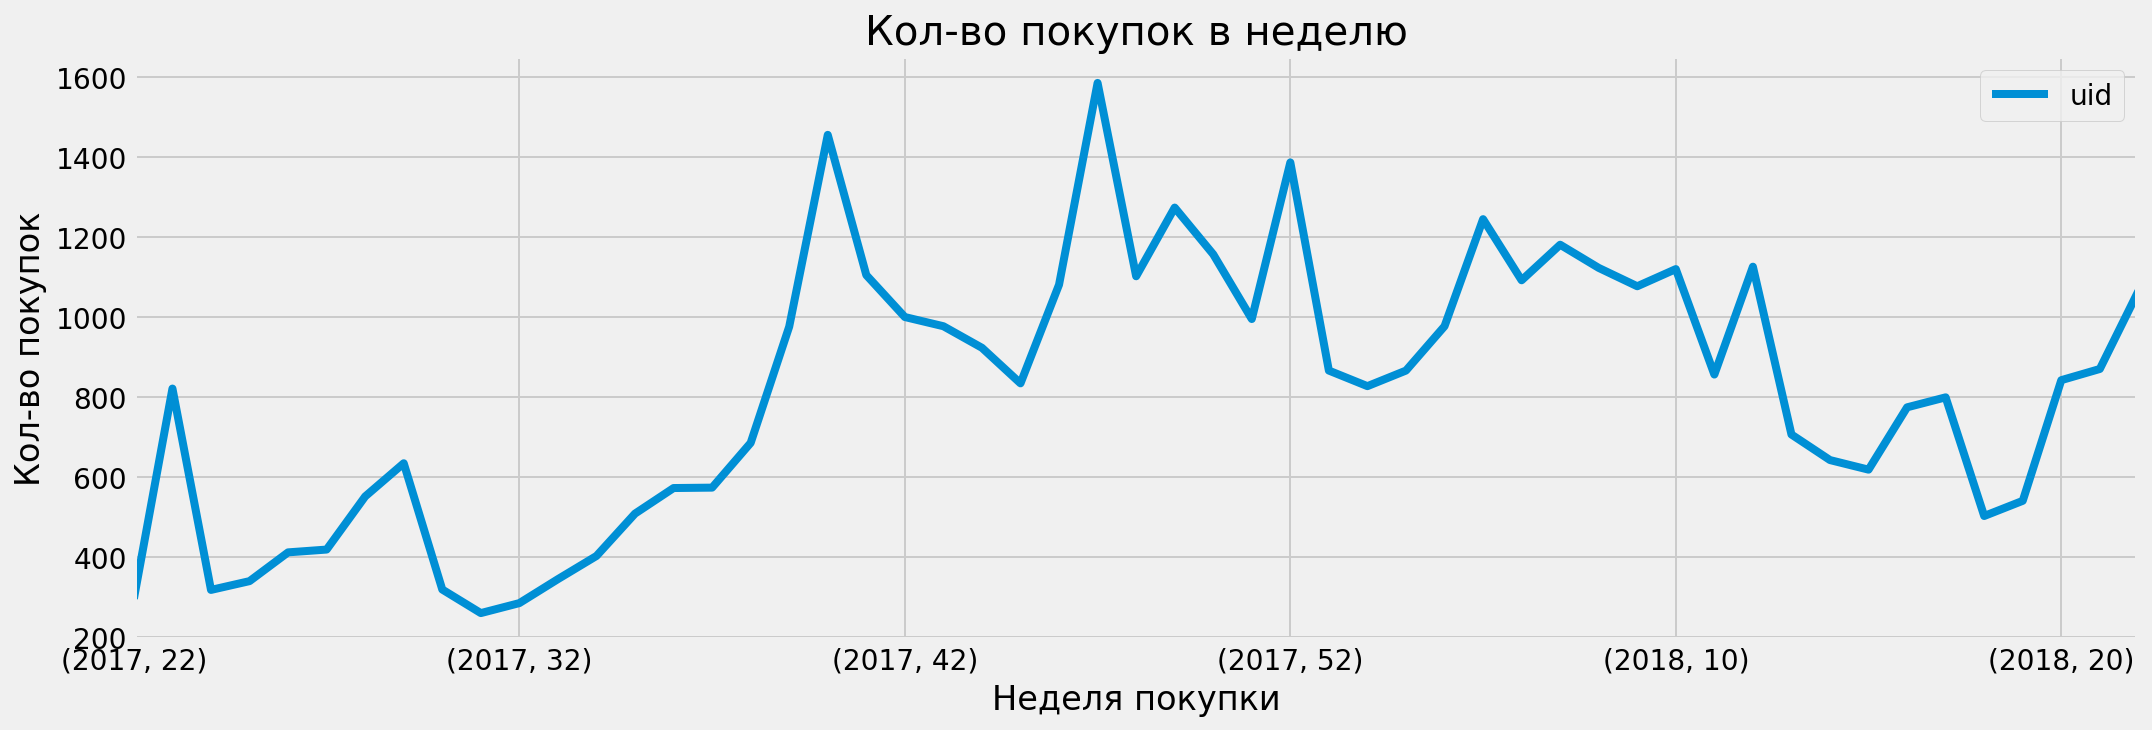

In [82]:
a2 = orders_by_week.plot(figsize=(16, 5));
a2.set_xlabel('Неделя покупки');
a2.set_ylabel('Кол-во покупок');
a2.set_title('Кол-во покупок в неделю');

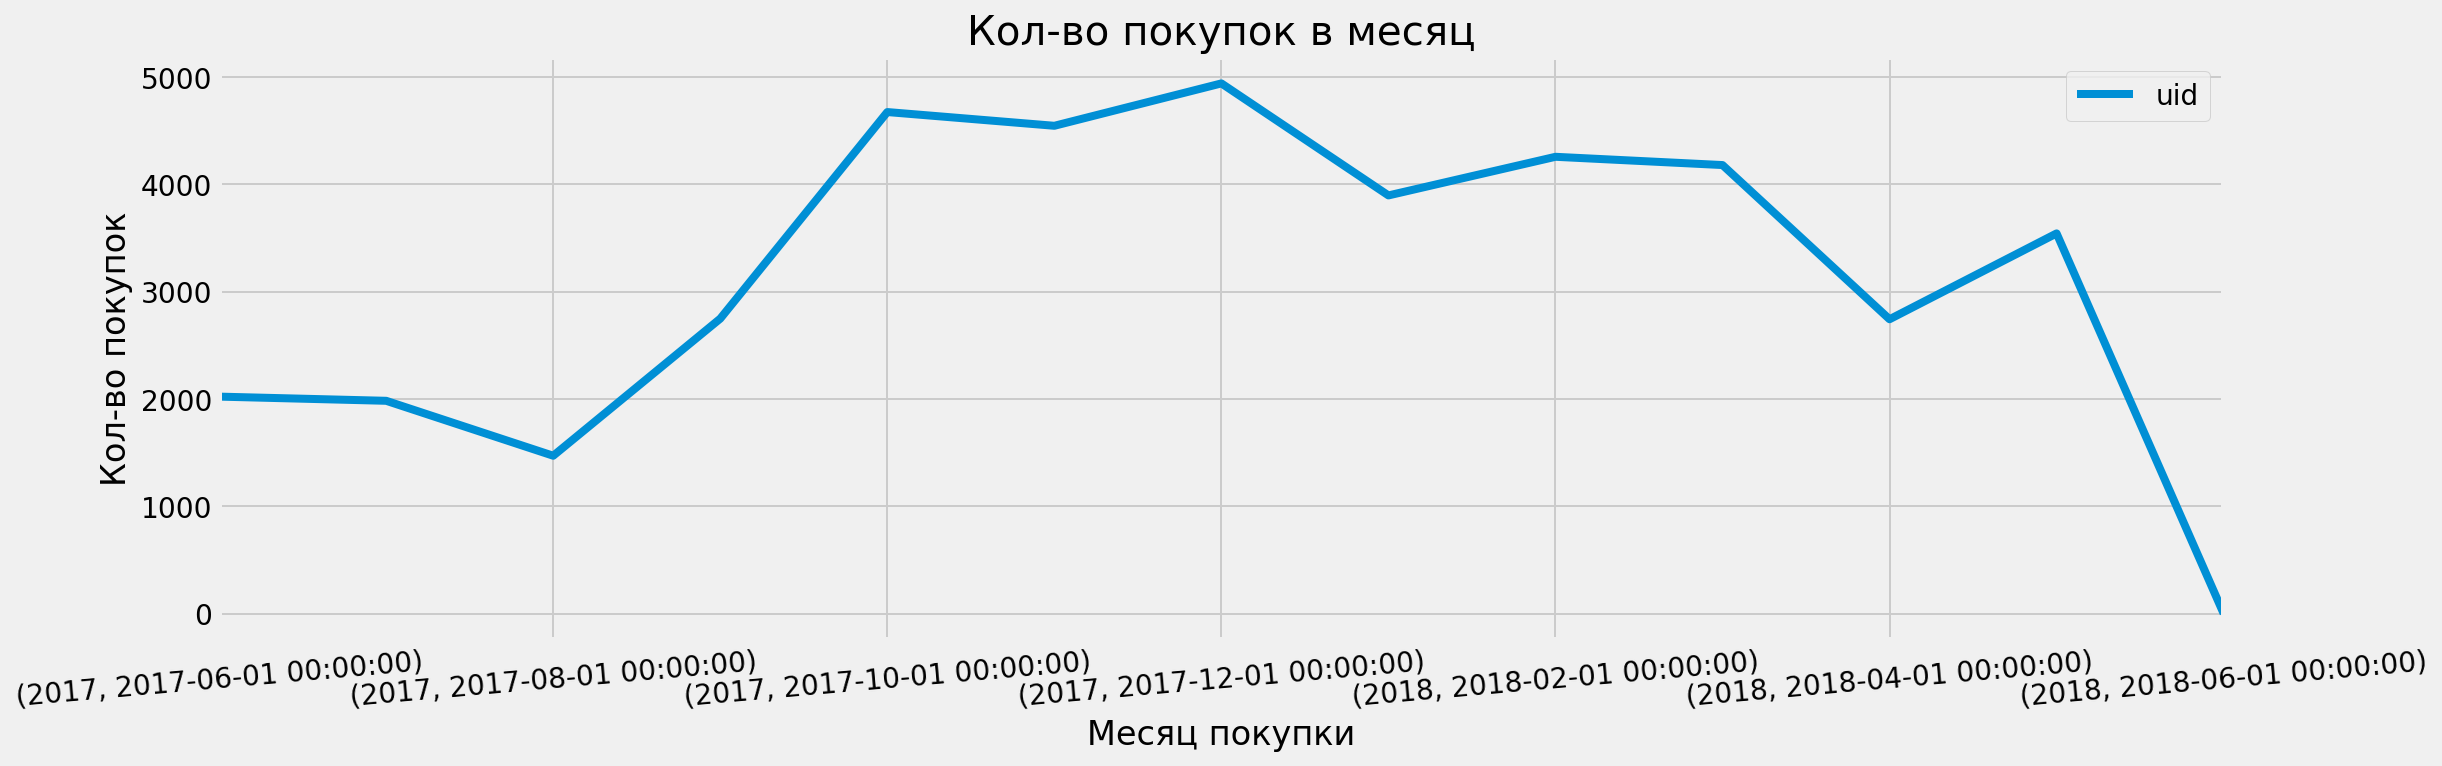

In [83]:
a3 = orders_by_month.plot(figsize=(16, 5), rot=5);
a3.set_xlabel('Месяц покупки');
a3.set_ylabel('Кол-во покупок');
a3.set_title('Кол-во покупок в месяц');

In [84]:
orders.head()

,buy_ts,revenue,uid,purchase_year,purchase_month,purchase_week,purchase_date,first_purchase_date,first_session_date,first_purchase_days
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0


In [85]:
orders_per_user = orders.groupby('purchase_month')['uid'].agg({'uid': ['count', 'nunique']})
display(orders_per_user)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


uid        
               count nunique
purchase_month              
2017-06-01      2354    2023
2017-07-01      2363    1984
2017-08-01      1807    1472
2017-09-01      3387    2750
2017-10-01      5679    4675
2017-11-01      5659    4547
2017-12-01      6218    4942
2018-01-01      4721    3898
2018-02-01      5281    4258
2018-03-01      5326    4181
2018-04-01      3273    2744
2018-05-01      4346    3544
2018-06-01         1       1

In [86]:
orders['revenue'].sum()

252057.2

In [87]:
orders_per_user['mean_orders'] = orders_per_user['uid']['count'] / orders_per_user['uid']['nunique']
display(orders_per_user)

uid         mean_orders
               count nunique            
purchase_month                          
2017-06-01      2354    2023    1.163618
2017-07-01      2363    1984    1.191028
2017-08-01      1807    1472    1.227582
2017-09-01      3387    2750    1.231636
2017-10-01      5679    4675    1.214759
2017-11-01      5659    4547    1.244557
2017-12-01      6218    4942    1.258195
2018-01-01      4721    3898    1.211134
2018-02-01      5281    4258    1.240254
2018-03-01      5326    4181    1.273858
2018-04-01      3273    2744    1.192784
2018-05-01      4346    3544    1.226298
2018-06-01         1       1    1.000000

Среднее количество покупок в месяц на одного пользователя:

In [88]:
orders_per_user['mean_orders'].mean()

1.2058233446244648

На графиках за неделю и месяц заметно, что *с августа 2017 года количество продаж возросло*.

Посчитаем **средний чек**:

In [89]:
avg_revenue = orders['revenue'].mean()
print('Средний чек:', avg_revenue)

Средний чек: 4.999646930477041


Получим более подрубную информацию о столбце `revenue`:

In [90]:
orders['revenue'].describe().to_frame()

,revenue
count,50415.000000
mean,4.999647
std,21.818359
min,0.000000
25%,1.220000
50%,2.500000
75%,4.890000
max,2633.280000


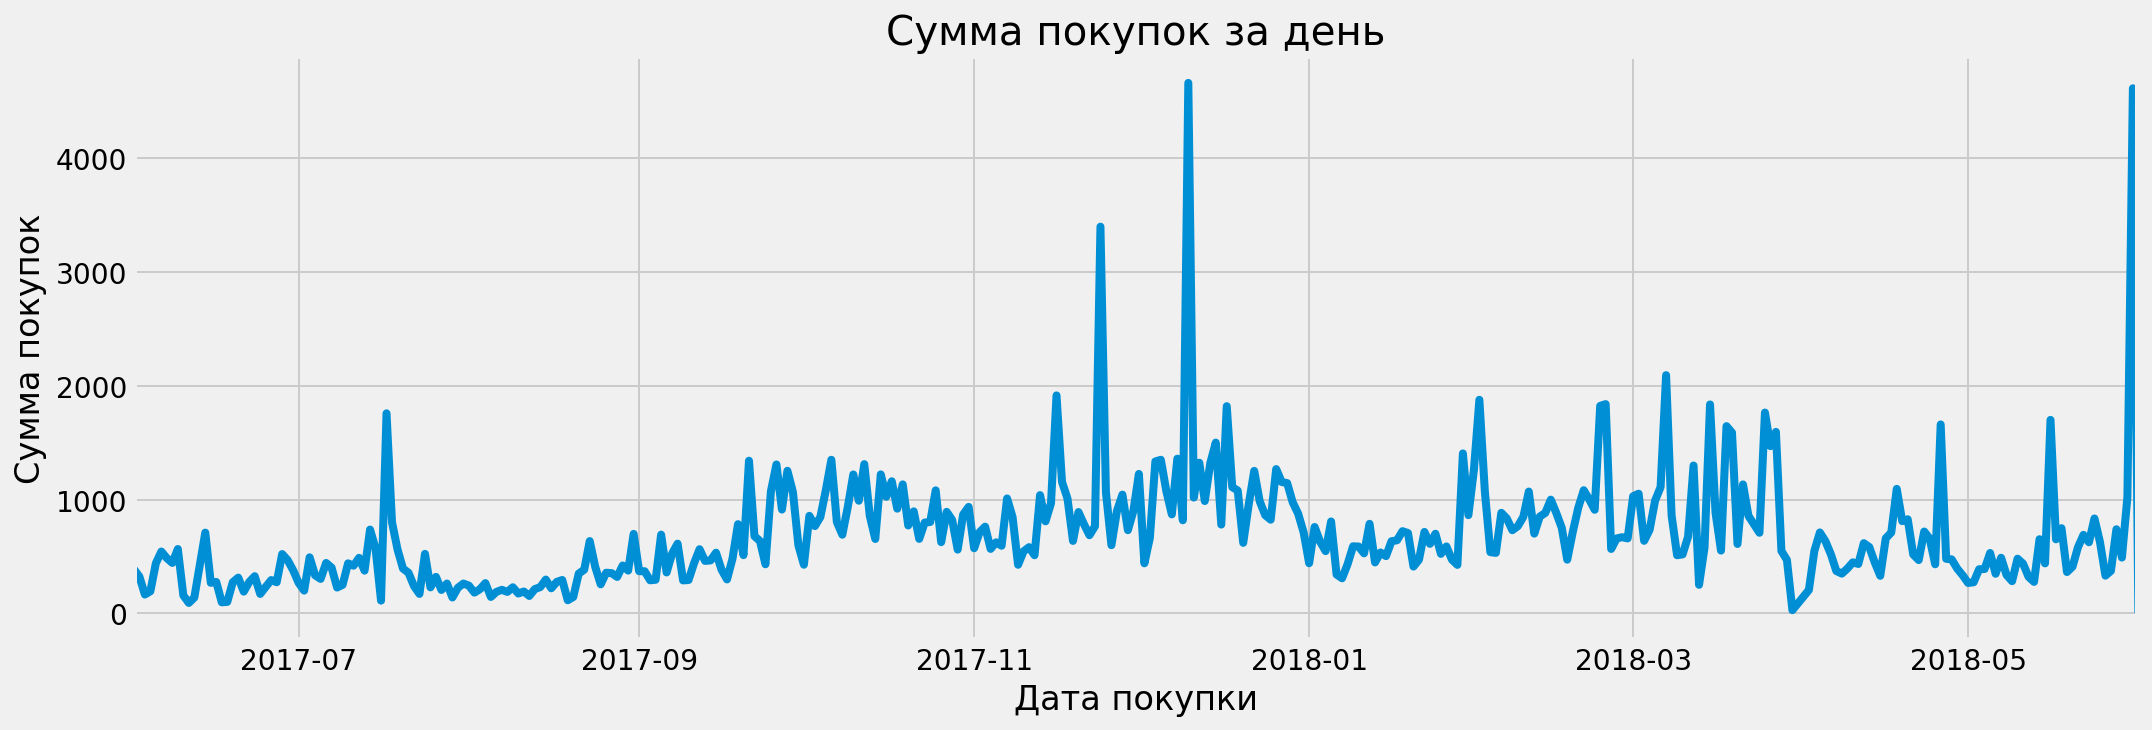

In [91]:
ax = orders.groupby('purchase_date')['revenue'].sum().plot(figsize=(16,5));
ax.set_xlabel('Дата покупки');
ax.set_ylabel('Сумма покупок');
ax.set_title('Сумма покупок за день');

Видим, что есть выбросы, но их мало.

Посчитаем, сколько денег приносят пользователи(**LTV**):

In [92]:
orders.head()

,buy_ts,revenue,uid,purchase_year,purchase_month,purchase_week,purchase_date,first_purchase_date,first_session_date,first_purchase_days
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0


Найдем для каждого пользователя месяц первой покупки и объеденим с таблицей `orders`:

In [93]:
first_purchase = orders.groupby('uid').agg({'purchase_month': 'min'}).reset_index()
first_purchase.columns = ['uid', 'first_purchase_month']

orders_new = pd.merge(orders,first_purchase, on='uid')
display(orders_new.head())

,buy_ts,revenue,uid,purchase_year,purchase_month,purchase_week,purchase_date,first_purchase_date,first_session_date,first_purchase_days,first_purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01


Посчитаем количество новых покупателейза каждый месяц:

In [94]:
orders['revenue'].sum()

252057.2

In [95]:
cohort_sizes = first_purchase.groupby('first_purchase_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_purchase_month', 'n_buyers']
display(cohort_sizes)

,first_purchase_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [96]:
orders['revenue'].sum()

252057.2

По количеству пользователей тоже заметно, что после августа 2017 начался рост. Возможно, в августе увеличились траты на маркетинг.

Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку:

In [97]:
cohorts = orders_new.groupby(['first_purchase_month','purchase_month']).agg({'revenue': 'sum'}).reset_index()
display(cohorts.head())

,first_purchase_month,purchase_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [98]:
orders['revenue'].sum()

252057.2

Проверим значения:

Добавим в таблицу `cohorts` данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [99]:
report = pd.merge(cohort_sizes, cohorts, on='first_purchase_month')
display(report.head()) 

,first_purchase_month,n_buyers,purchase_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Проверим суммы по доходу:

In [100]:
print(cohorts['revenue'].sum(), orders['revenue'].sum(), report['revenue'].sum())

252057.19999999934 252057.2 252057.19999999934


За неимением данных о маржинальности, примем ее за 100% и посчитаем **ltv**:

In [101]:
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate

report['first_purchase_month'] = report['first_purchase_month'].astype('datetime64[M]')
report['age'] = (report['purchase_month'] - report['first_purchase_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['ltv'] = report['gp'] / report['n_buyers']

display(report.head()) 

,first_purchase_month,n_buyers,purchase_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531


Построим сводную таблицу:

In [102]:
report_pyvot = report.pivot_table(
        index='first_purchase_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')

#display(report_pyvot.fillna(''))

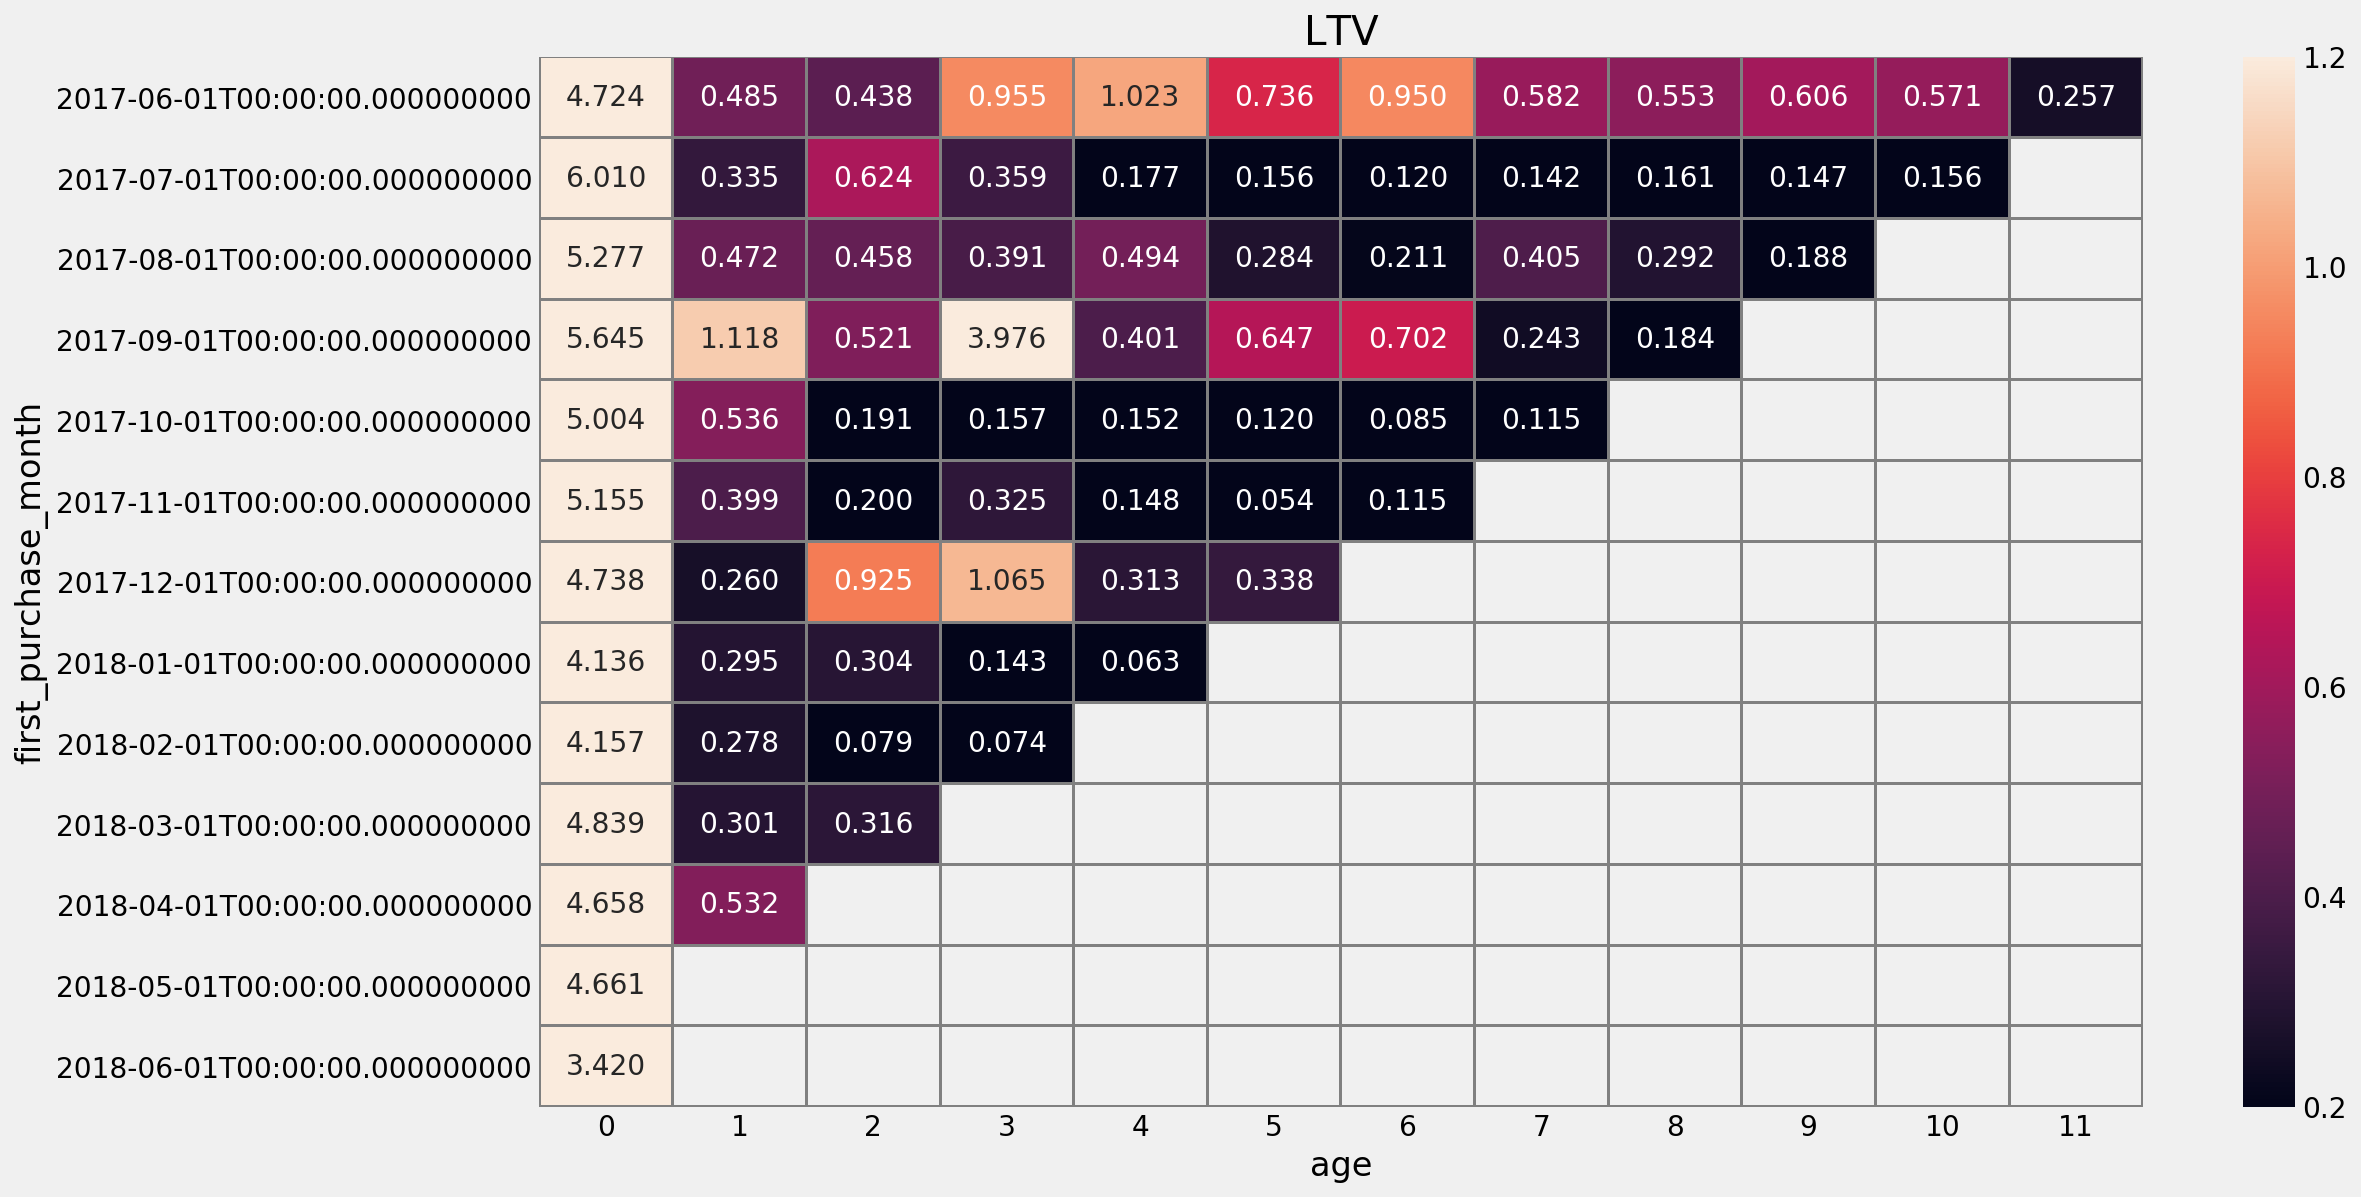

In [106]:
plt.figure(figsize=(16, 9))
plt.title('LTV')
sns.heatmap(report_pyvot, annot=True, fmt='.3f', linewidths=1, linecolor='gray', vmin=0.2, vmax=1.2);

Видим, что *первая когорта приносит больше всего денег*. Также отмечаем, что *сентябрьская когорта принесла больше всего денег в декабре*, при чем у других когорт такого всплеска не наблюдается.

### Маркетинг

[Вернуться в начало](#Оптимизация-маркетинговых-затрат-в-Яндекс.Афише)

Посчитаем, **сколько денег потратили** всего / на каждый источник / по времени:

In [107]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [108]:
total_costs = costs['costs'].sum()
print('Всего на маркетинг потратили:', total_costs)

Всего на маркетинг потратили: 329131.62


In [109]:
source_costs = costs.groupby('source_id')['costs'].sum().reset_index()
display(source_costs)
print('В среднем на каждый источник потратили: {:.1f}'.format(source_costs['costs'].mean()))

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


В среднем на каждый источник потратили: 47018.8


Видим, что *больше всего потратили на 3 источник*, а *меньше всего - на 9 и 10*. На 6, 7, и 8 источники не тратили денег вовсе. Возможно, стоит от них отказаться за ненадобностью.

Посчитаем, **сколько стоило привлечение одного покупателя из каждого источника**:

In [110]:
orders.head()

,buy_ts,revenue,uid,purchase_year,purchase_month,purchase_week,purchase_date,first_purchase_date,first_session_date,first_purchase_days
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,2017-06-01,22,2017-06-01,2017-06-01,2017-06-01,0


Выберем только людей совершивших покупку:

In [111]:
# определяем первый источник пользователя
sources = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})

# соединяем первые покупки и источники 
payers = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})

In [112]:
cohort_sizes = payers.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})

display(cohort_sizes)

,cohort_size
source_id,
1,2899
2,3506
3,10473
4,10296
5,6931
7,1
9,1088
10,1329


Проверим количество уникальных покупателей:

In [113]:
cohort_sizes.sum() == len(orders['uid'].unique())

cohort_size    True
dtype: bool

*В лидерах по привлеченным клиентам* 3 и 4 источники (по тратам они тоже топ-2, но в другом порядке). Также отмечаем, что из 6 и 8 источников не пришло *ни одного клиента*. А из 8 канала пришел только один. Наверное, эти каналы не работают.

Посчитаем CAC:

In [114]:
cac_report = pd.merge(cohort_sizes, source_costs, on='source_id')
cac_report['cac'] = cac_report['costs'] / cac_report['cohort_size']
display(cac_report)

,source_id,cohort_size,costs,cac
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10296,61073.60,5.931779
4,5,6931,51757.10,7.467479
5,9,1088,5517.49,5.071222
6,10,1329,5822.49,4.381106


Видим, что дешевле всего стоят клиенты из 9 и 10 источников, на которые потратили меньше всего денег. Возможно, *стоит сделать больший акцент на эти источники*.

Посчитаем, на сколько окупились расходы? (**ROI**)

In [115]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Сгруппируем траты по месяцам:

In [116]:
costs['month'] = costs['dt'].astype('datetime64[M]') 

monthly_costs = costs.groupby('month')['costs'].sum()
display(monthly_costs.to_frame())

,costs
month,
2017-06-01,18015.00
2017-07-01,18240.59
2017-08-01,14790.54
2017-09-01,24368.91
2017-10-01,36322.88
2017-11-01,37907.88
2017-12-01,38315.35
2018-01-01,33518.52
2018-02-01,32723.03


И правда, видим, что с августа 2017 траты на маркетинг начали увеличиваться. А за ними и количество клиентов.

Добавим траты по месяцам в таблицу `report` и посчитаем САС:

In [117]:
report_new = pd.merge(report, monthly_costs, left_on='first_purchase_month', right_on='month')

report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head() 

,first_purchase_month,n_buyers,purchase_month,revenue,gp,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531,18015.0,8.905091


Посчитаем ROMI:

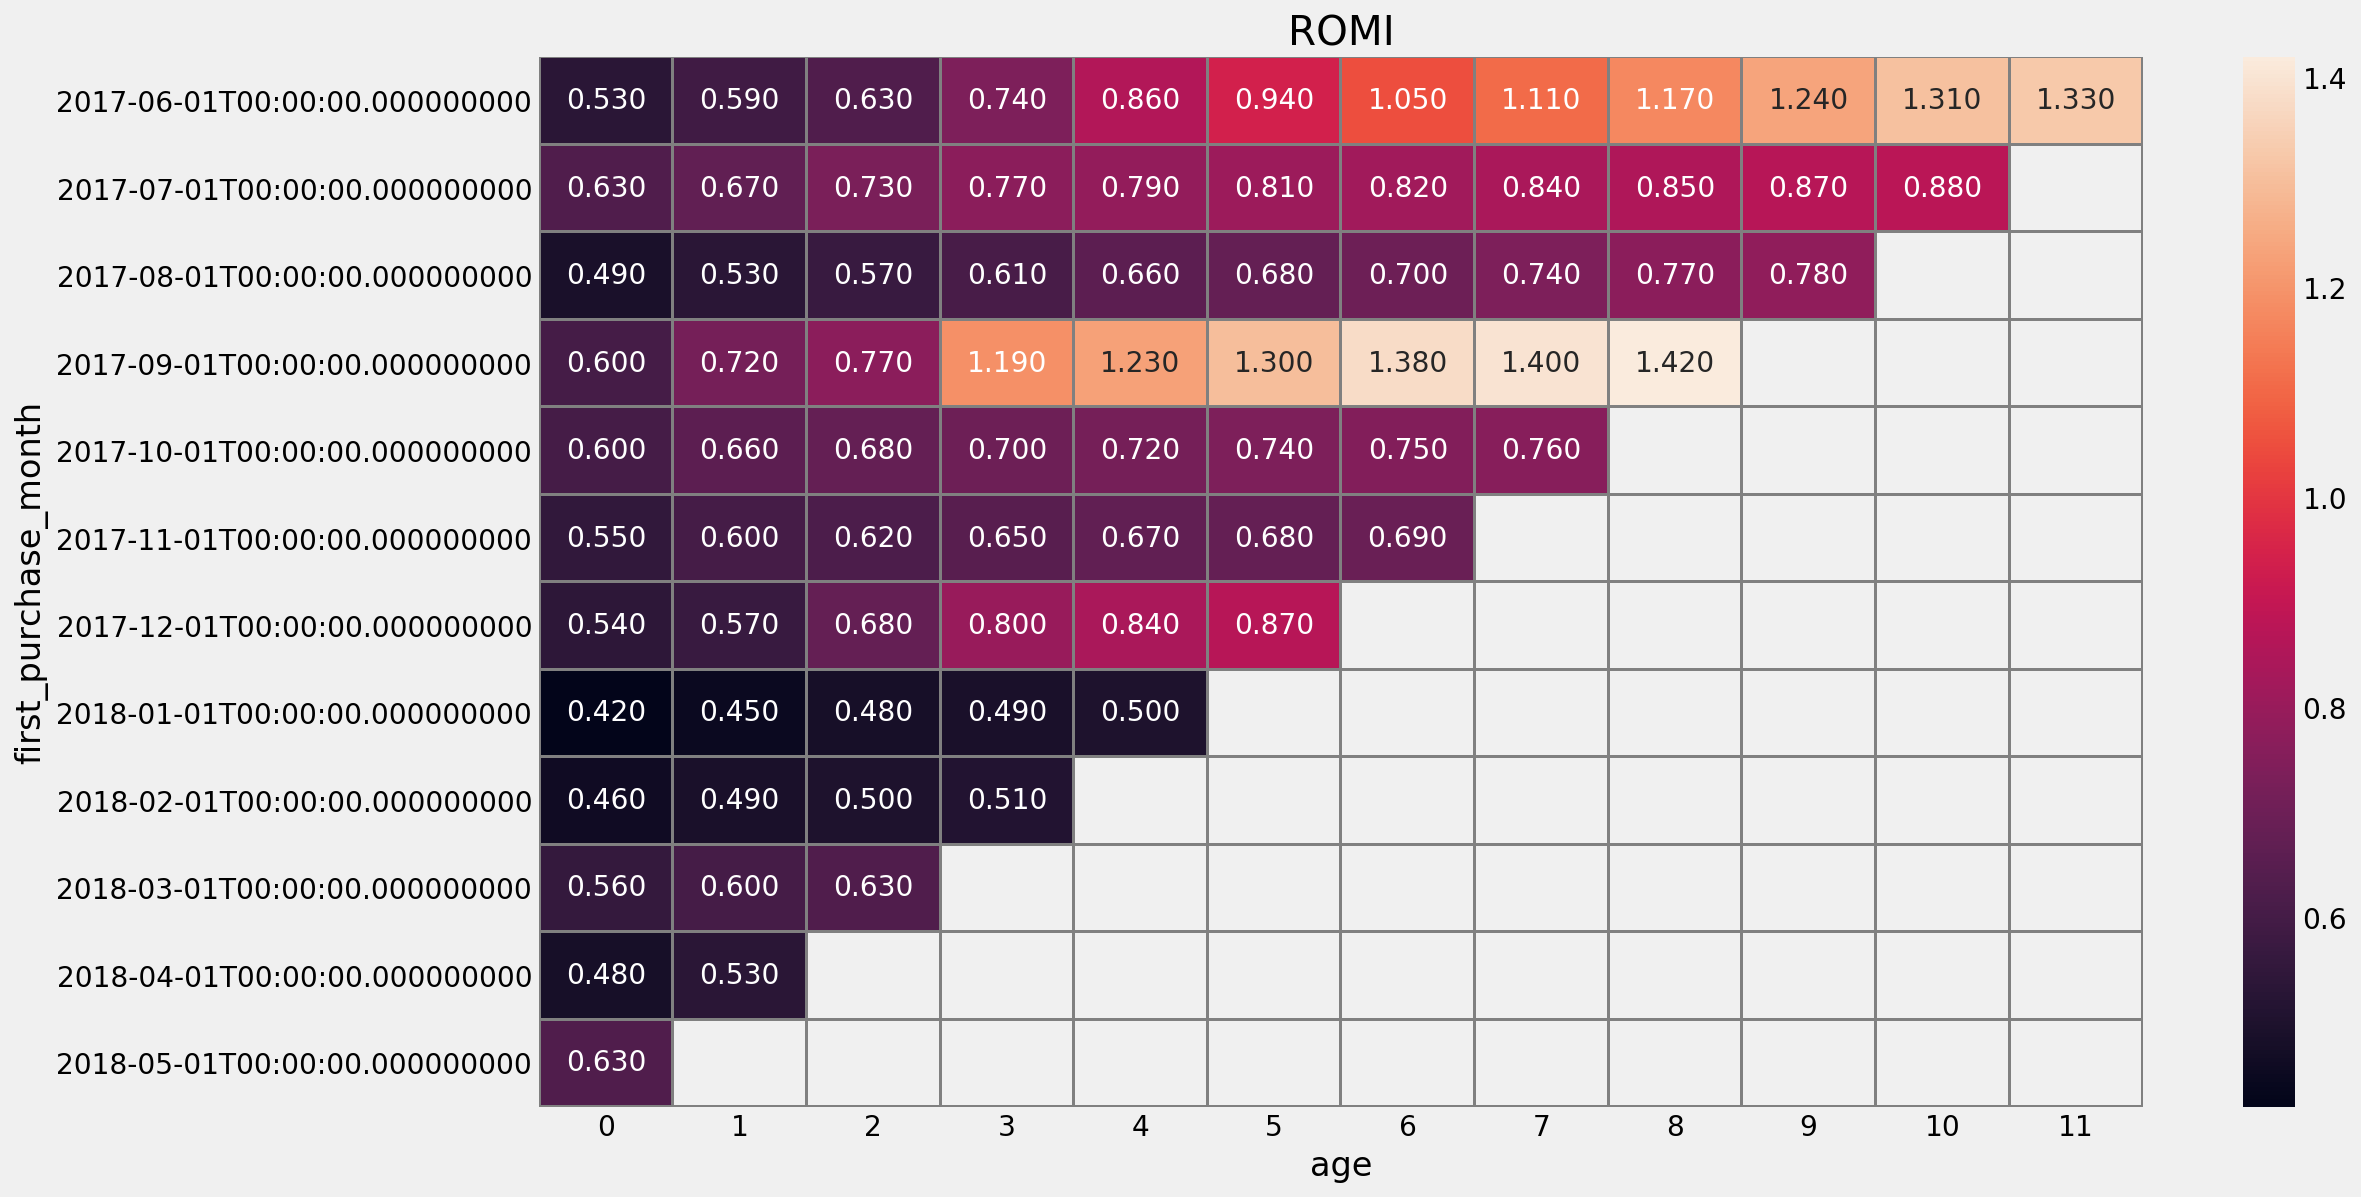

In [118]:
report_new['romi'] = report_new['ltv'] / report_new['cac']

output = report_new.pivot_table(
        index='first_purchase_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

#display(output.cumsum(axis=1).round(2).fillna(''))

plt.figure(figsize=(16, 9))
plt.title('ROMI')
sns.heatmap(output.cumsum(axis=1).round(2), annot=True, fmt='.3f', linewidths=1, linecolor='gray');

Посчитаем среднюю когорту:

In [120]:
output.cumsum(axis=1).mean(axis=0).to_frame()

,0
age,
0,0.540816
1,0.581985
2,0.631069
3,0.719740
4,0.782946
5,0.859876
6,0.896819
7,0.969951
8,1.053871


Затраты на маркетинг в среднем окупаются за 8 месяцев. Лучше всего окупались первая и третья когорты. Точнее за данный период только они и окупились. Еще на графике можно заметить сезонность romi. Каждые три месяца(кстати, это как раз всегда первый месяц лета/осени и тд) romi подскакивал, а потом следующие два месяца постепенно уменьшался. Возможно, просто совпадение, но выглядит интересно, стоит изучить этот вопрос поподробнее.

**В разбивке по источникам**:

In [121]:
# считаем ltv
ltv = payers.merge(orders, on = 'uid')
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy']) / np.timedelta64(1,'M')).round().astype(int)
ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
ltv = ltv.cumsum(axis = 1)

# делим на размеры когорт
ltv = ltv.merge(cohort_sizes, on = 'source_id')
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size')
#display(ltv)

# считаем САС
cac = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index().merge(cohort_sizes.reset_index(), on = 'source_id')
cac['cac'] = cac['costs'] / cac['cohort_size']
cac = cac.set_index('source_id')
#display(cac)

# считаем ROMI
romi = ltv.merge(cac[['cac']], on = 'source_id')
romi = romi.div(romi['cac'], axis = 0).drop(columns = 'cac')
#display(romi)

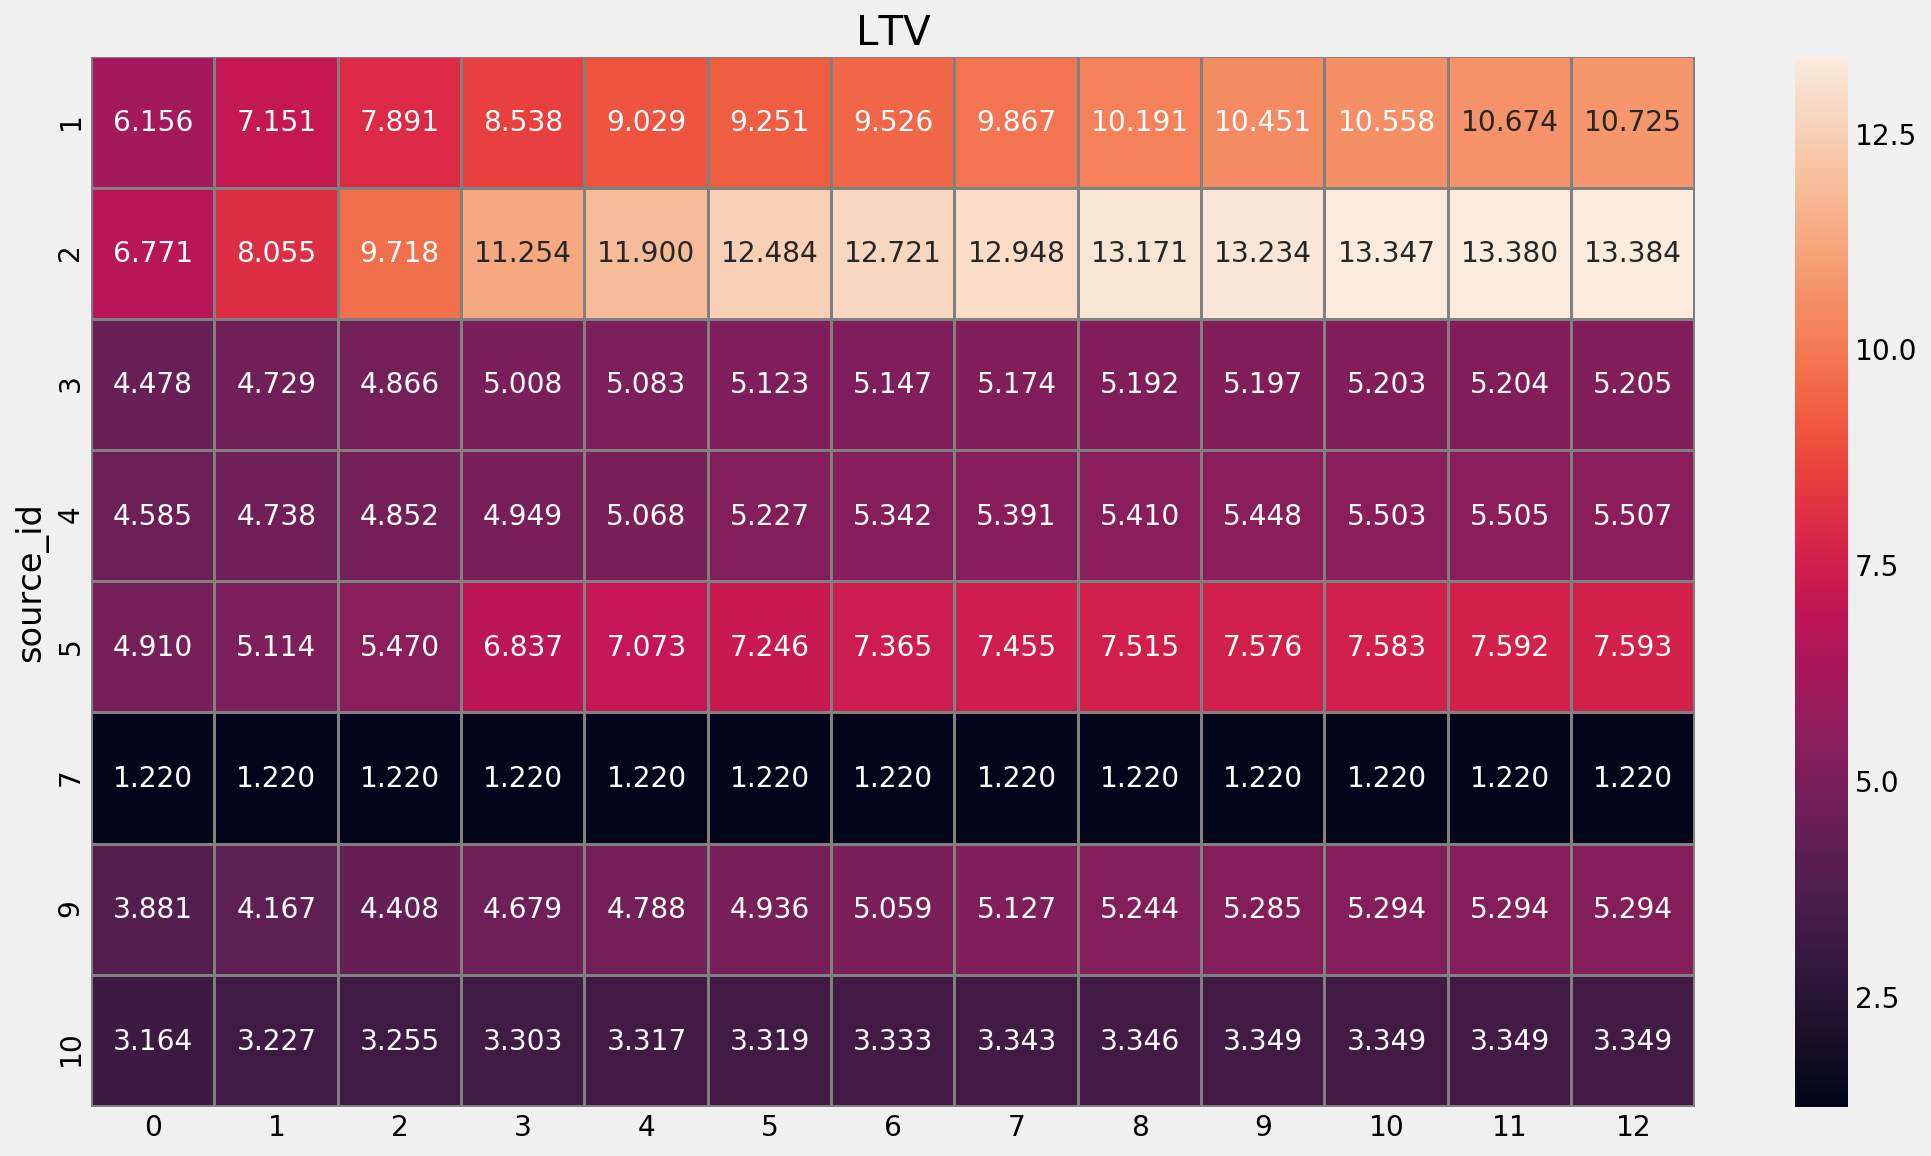

In [122]:
plt.figure(figsize=(16, 9))
plt.title('LTV')
sns.heatmap(ltv, annot=True, fmt='.3f', linewidths=1, linecolor='gray');

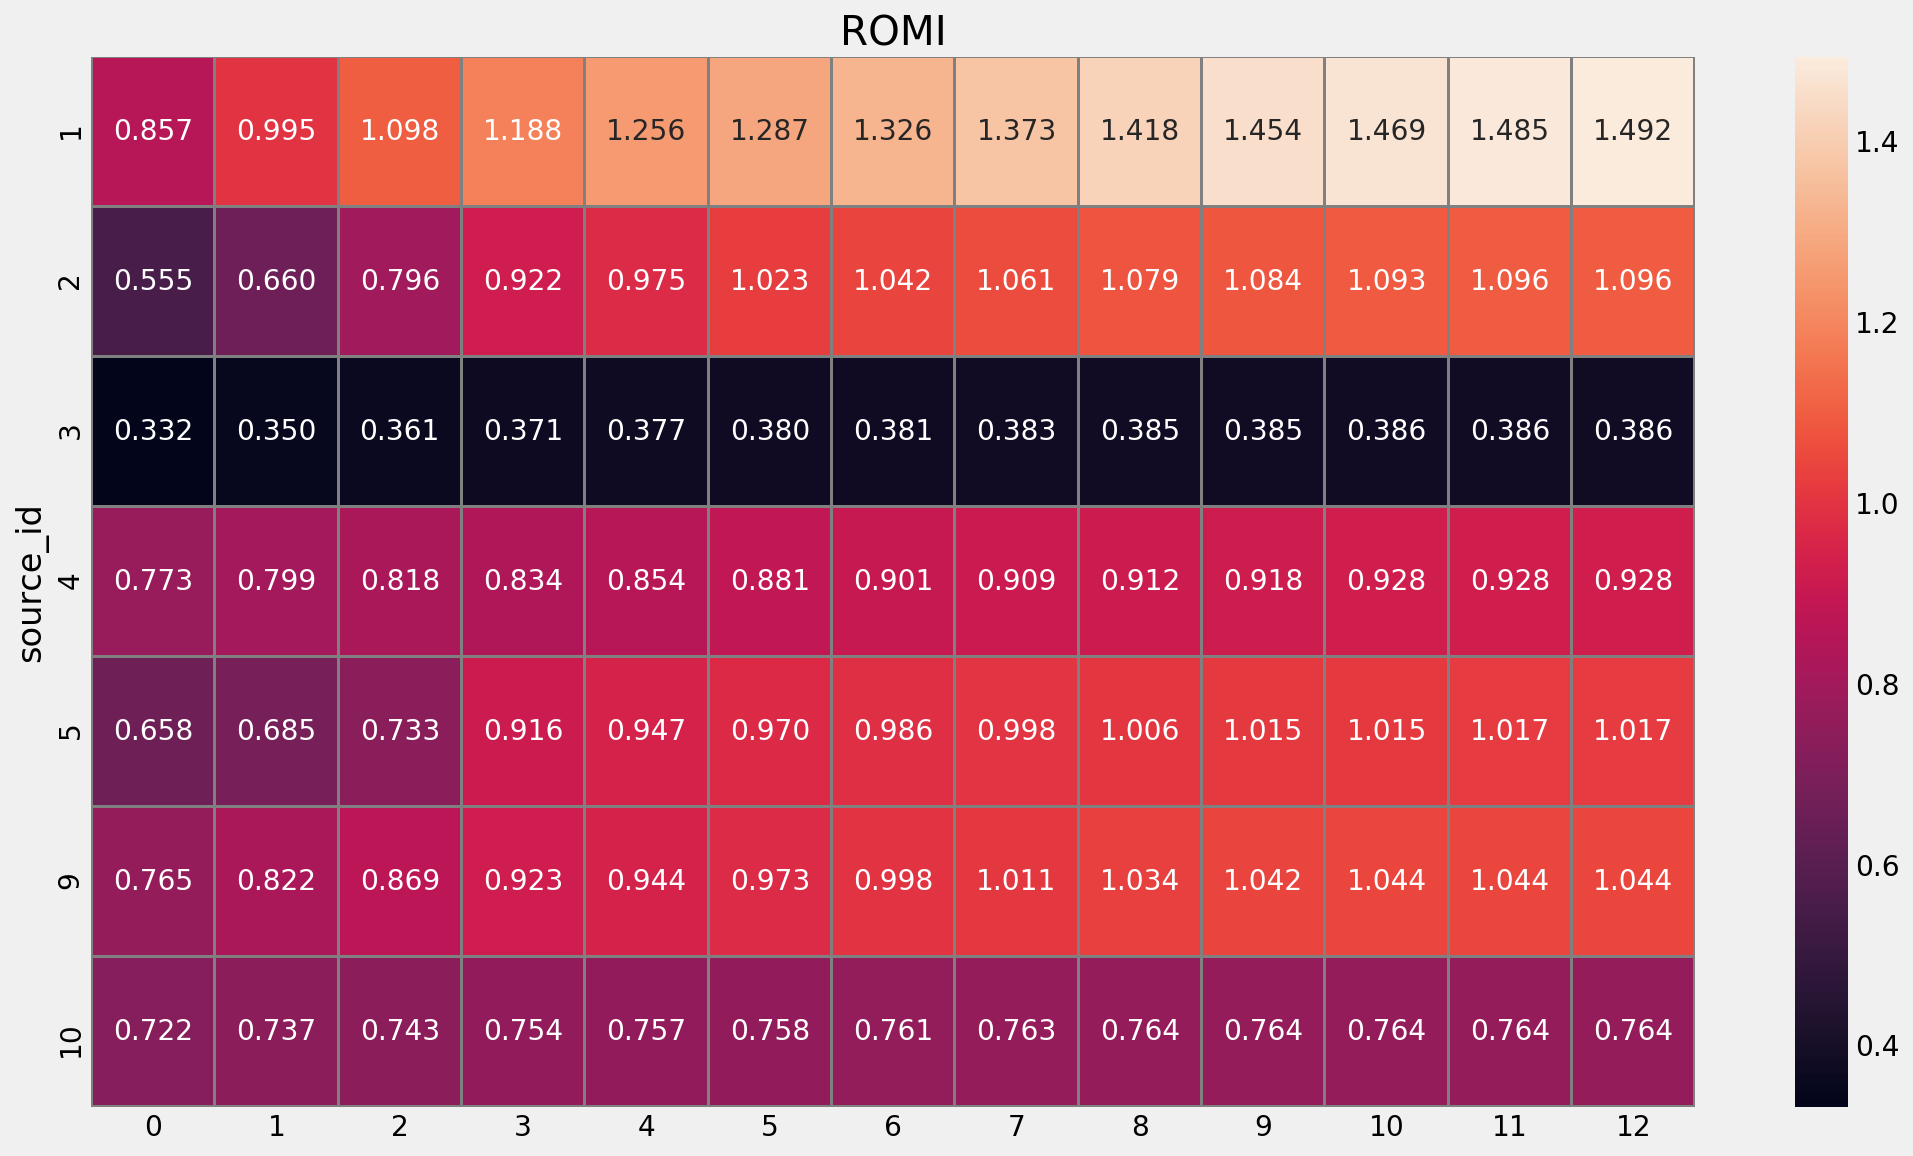

In [123]:
plt.figure(figsize=(16, 9))
plt.title('ROMI')
sns.heatmap(romi, annot=True, fmt='.3f', linewidths=1, linecolor='gray');

Затраты на маркетинг окупаются у 1, 2, 5 и 9 источников. Именно на них и стоит делать упор в дальнейшем. Лучше всего себя показал 1 источник, почти окупившийся за два месяца. Возможно, стоит подумать о том, чтобы реанимировать 7 источник, ведь он даже без затрат примес деньги.


### Шаг 3. Вывод

**Краткий обзор проведённой работы:**
Открыли и изучили общую информацию, заменили названия столбцов, привели данные к нужным типам, изучили, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент и когда клиент окупается.

**Главные выводы:** 
- Повторных покупок очень мало - Retention rate резко падает уже в первом месяце, и остается почти неизменным в дальнейшем.

- С августа 2017 года количество продаж возросло вслед за увеличением трат на маркетинг.

- Первая когорта приносит больше всего денег.

- Больше всего потратили на 3 источник, а меньше всего - на 9 и 10. При этом на 6, 7 и 8 источники не тратили денег вовсе, но и клиентов они не привлекли. Возможно, стоит от них отказаться за ненадобностью. В лидерах по привлеченным клиентам 3 и 4 источники (по тратам они тоже топ-2, но в другом порядке). 

- Затраты на маркетинг отлично окупаются у 1, 2 и 5 источников. Они же и принесли больше всего денег. Именно на них и стоит делать упор в дальнейшем.

[Вернуться в начало](#Оптимизация-маркетинговых-затрат-в-Яндекс.Афише)